# Introduction to Deep Learning
## Assignment 3
### Task 1: Recurrent Neural Networks
<img src="https://miro.medium.com/max/1400/1*1JcHGUU7rFgtXC_mydUA_Q.jpeg" width="500"> 

The goal of this task is to learn how to use encoder-decoder recurrent models. Specifically we will be dealing with a sequence to sequence problem and try to develop a neural network that can learn the principles behind simple arithmetic operations.



To work on this notebook you should create a copy of it.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell, Dropout
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

# Function definitions for creating the dataset

In order to create image queries of simple arithmetic operations such as '51+31' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset.

In [2]:
# Create plus/minus signs
def generate_images(cross=False, n=50):
    x = np.random.randint(12, 16, (n, 2))
    y1 = np.random.randint(4, 8, n)
    y2 = np.random.randint(20, 24, n)
    
    blank = np.zeros([n, 28, 28])
    for i in range(n):
        line = cv2.line(blank[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)
        if cross:
            line = cv2.line(blank[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank

def show_generated(images):
    for i in range(20):
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

#show_generated(generate_images())
#show_generated(generate_images(cross=True))

In [3]:
import random

def create_data(highest_integer):
    """
    Creates the following data for all pairs of integers up to [highest integer]+[highest_integer]:

    @return:
    X_text: '151+ 21' -> text query of an arithmetic operation
    X_img : Stack of MNIST images corresponding to the query (7 x 28 x 28)
    y_text: ' 172' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (4 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(cross=True)
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []
    for i in range(highest_integer + 1):
        for j in range(highest_integer + 1):
            
            i_char = to_padded_chars(i, max_len=max_int_length)
            j_char = to_padded_chars(j, max_len=max_int_length)

            for sign in ['-', '+']:
                query_string = i_char + sign + j_char
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))
            
    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.
  
def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 80000 samples that have two kinds of inputs and labels:

  X_text: strings containing queries of length 7: ['  1+  1', '174- 18', ...] 

  X_image: a stack of images representing a single query, dimensions: [7, 28, 28]

  y_text: strings containing answers of length 4: ['   2', ' 156']

  y_image: a stack of images that represents the answer to a query, dimensions: [4, 28, 28]

In [4]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- ' # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 199 # Highest value of integers contained in the queries
max_int_length = len(str(highest_integer)) # 
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = max_int_length + 1    # Maximum length of the answer string

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labs = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        plt.axis('off')
        plt.title(labs[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nSample ID: {n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

#for _ in range(10):
#    display_sample(np.random.randint(0, 80000, 1)[0])

11501568/11490434 [==============================] - 0s 0us/step
(80000,) (80000, 7, 28, 28) (80000,) (80000, 4, 28, 28)


In [5]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=4):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)])
        for j, char in enumerate(label):
            m[j, char_map[char]] = 1
        one_hot[i] = m

    return one_hot 

def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])
    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(80000, 7, 13) (80000, 4, 13)


---
---

# 1.1 Text-to-text RNN model

The following code showcases how Recurrent neural networks are built using Keras. Several new layers are going to be used:

1. LSTM 
2. TimeDistributed
3. RepeatVector

The following code shows the basic architecture of a Recurrent Neural Network
LSTM (Long Short Term Memory) layers can be replaced either with SimpleRNN or GRU (Gated Recurrent Units).



<img src="https://miro.medium.com/max/1400/1*1JcHGUU7rFgtXC_mydUA_Q.jpeg" width="500"> 


In [ ]:
# We start by initializing a sequential model
text2text = tf.keras.Sequential()

# "Encode" the input sequence using an RNN, producing an output of size 256.
# In this case the size of our input vectors is [7, 13] as we have queries of length 7 and 13 unique characters. Each of these 7 elements in the query will be fed to the network one by one,
# as shown in the image above (except with 7 elements).
# Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
text2text.add(LSTM(256, input_shape=(max_query_length, len(unique_characters))))

# As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 4 times as that's the maximum length of the output (e.g. '  1-199' = '-198')
# when using 3-digit integers in queries. In other words, the RNN will always produce 4 characters as its output.
text2text.add(RepeatVector(max_answer_length))

# By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
# the first dimension to be the timesteps.
text2text.add(LSTM(128, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
text2text.add(TimeDistributed(Dense(len(unique_characters), activation='sigmoid')))

# Next we compile the model using categorical crossentropy as our loss function.
text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
text2text.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               276480    
                                                                 
 repeat_vector (RepeatVector  (None, 4, 256)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 4, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 4, 13)            1677      
 ibuted)                                                         
                                                                 
Total params: 475,277
Trainable params: 475,277
Non-trainable params: 0
_________________________________________________________________


### Your tasks:


# 1.2 Testing and evaluating accuracy and generalization: capabilites

In [ ]:
# Train and experiment with the text-to-text RNN Model by using X_text and y_text as your inputs/outputs
# 1. Try different ratios of train/test splits

splits = []

for split in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    text2text = tf.keras.Sequential()
    text2text.add(LSTM(256, input_shape=(max_query_length, len(unique_characters))))
    text2text.add(RepeatVector(max_answer_length))
    text2text.add(LSTM(128, return_sequences=True))
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
    text2text.compile(loss='CategoricalCrossentropy', optimizer='rmsprop', metrics=['accuracy'])

    history = text2text.fit(X_text_onehot, y_text_onehot, batch_size=64, epochs=10, validation_split=split)
    splits.append([split, history.history["val_accuracy"]])

Epoch 1/10
1125/1125 [==============================] - 18s 13ms/step - loss: 1.3195 - accuracy: 0.4837 - val_loss: 1.2785 - val_accuracy: 0.4992
Epoch 2/10
1125/1125 [==============================] - 13s 12ms/step - loss: 1.0152 - accuracy: 0.6026 - val_loss: 1.0912 - val_accuracy: 0.5478
Epoch 3/10
1125/1125 [==============================] - 13s 12ms/step - loss: 0.8749 - accuracy: 0.6536 - val_loss: 1.1129 - val_accuracy: 0.5474
Epoch 4/10
1125/1125 [==============================] - 13s 12ms/step - loss: 0.7988 - accuracy: 0.6866 - val_loss: 1.1218 - val_accuracy: 0.5637
Epoch 5/10
1125/1125 [==============================] - 13s 12ms/step - loss: 0.6218 - accuracy: 0.7627 - val_loss: 0.8713 - val_accuracy: 0.6633
Epoch 6/10
1125/1125 [==============================] - 14s 12ms/step - loss: 0.3643 - accuracy: 0.8779 - val_loss: 0.7008 - val_accuracy: 0.7122
Epoch 7/10
1125/1125 [==============================] - 13s 12ms/step - loss: 0.2202 - accuracy: 0.9352 - val_loss: 0.4838 -

Validation split fraction: 0.1. Accuracy achieved: 0.7418437600135803
Validation split fraction: 0.2. Accuracy achieved: 0.5222031474113464
Validation split fraction: 0.3. Accuracy achieved: 0.46811458468437195
Validation split fraction: 0.4. Accuracy achieved: 0.42408594489097595
Validation split fraction: 0.5. Accuracy achieved: 0.3708375096321106
Validation split fraction: 0.6. Accuracy achieved: 0.38646355271339417
Validation split fraction: 0.7. Accuracy achieved: 0.3206830322742462
Validation split fraction: 0.8. Accuracy achieved: 0.3322838842868805
Validation split fraction: 0.9. Accuracy achieved: 0.388966828584671


Text(0, 0.5, 'Accuracy')

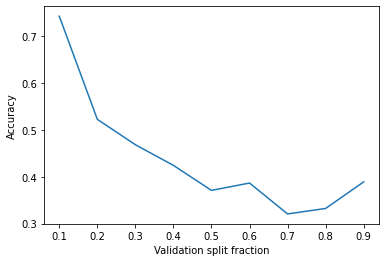

In [ ]:
# Plot results

xplot = []
yplot = []

for i in range(0,len(splits)):
  xplot.append(splits[i][0])
  yplot.append(splits[i][1][9])
  print(f"Validation split fraction: {splits[i][0]}. Accuracy achieved:", splits[i][1][9])

plt.figure()
plt.plot(xplot, yplot)
plt.xlabel("Validation split fraction")
plt.ylabel("Accuracy")

In [ ]:
# 2. Try to find more optimal architectures
# TBD, think we can leave that to the end, since its just experimenting a bit
print(y_text_onehot[0])
#check images: best found: Softmax - adam

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]



---
---

# 1.3 Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use X_img as inputs and y_text as outputs.

In [6]:
# So for input Img we want this shape input (Ximg, len(Ximg), 7, 28, 28) for convolutional, but for LSTM just the pixels in a vector: (7, 784)
X_img_flat = X_img.reshape(80000, 7, 784)

In [9]:

# structure from previously

# X_text, X_img, y_img, y_text

lstm_img2text = tf.keras.Sequential()
lstm_img2text.add(LSTM(256, input_shape=(7, 784), dropout=0.2))
lstm_img2text.add(RepeatVector(max_answer_length))
lstm_img2text.add(LSTM(128, return_sequences=True, dropout=0.2))
lstm_img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

lstm_img2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_img2text.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               1065984   
                                                                 
 repeat_vector_1 (RepeatVect  (None, 4, 256)           0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 4, 128)            197120    
                                                                 
 time_distributed_1 (TimeDis  (None, 4, 13)            1677      
 tributed)                                                       
                                                                 
Total params: 1,264,781
Trainable params: 1,264,781
Non-trainable params: 0
_________________________________________________________________


In [10]:
#Note that input here is X_img_FLAT
history = lstm_img2text.fit(X_img_flat, y_text_onehot, batch_size=128, epochs=30, validation_split=0.2)


Epoch 1/30
500/500 [==============================] - 15s 23ms/step - loss: 1.4289 - accuracy: 0.4465 - val_loss: 1.4784 - val_accuracy: 0.3893
Epoch 2/30
500/500 [==============================] - 10s 20ms/step - loss: 1.2554 - accuracy: 0.5060 - val_loss: 1.4672 - val_accuracy: 0.4519
Epoch 3/30
500/500 [==============================] - 10s 20ms/step - loss: 1.1843 - accuracy: 0.5368 - val_loss: 1.6753 - val_accuracy: 0.4214
Epoch 4/30
500/500 [==============================] - 10s 21ms/step - loss: 1.1122 - accuracy: 0.5641 - val_loss: 1.6952 - val_accuracy: 0.4510
Epoch 5/30
500/500 [==============================] - 11s 22ms/step - loss: 1.0620 - accuracy: 0.5816 - val_loss: 1.7691 - val_accuracy: 0.4513
Epoch 6/30
500/500 [==============================] - 11s 22ms/step - loss: 1.0269 - accuracy: 0.5968 - val_loss: 2.0914 - val_accuracy: 0.4303
Epoch 7/30
500/500 [==============================] - 11s 21ms/step - loss: 1.0017 - accuracy: 0.6067 - val_loss: 2.0602 - val_accuracy:

---
---

# 1.4 Text to image RNN Model

Hint: to make this model work well you will need deconvolutional layers in your decoder (look up ***Conv2DTranspose*** layer). To connect this from a flat latent vector you will also need an operation which is opposite to a ***Flatten*** layer that you usually use in convolutional architectures - for this look up the ***Reshape*** layer.

The goal here is to use X_text as inputs and y_img as outputs.

In [ ]:
X_text_onehot_flat = X_text_onehot.reshape(80000,91)
y_img_4in1 = y_img.reshape(80000, 112, 28)

In [ ]:
tf.keras.backend.clear_session()

text2img = tf.keras.Sequential()
text2img.add(Dense(784, input_shape = (91,), activation='relu'))
#text2img.add(Dropout(0.3))
text2img.add(Dense(3136, activation='relu'))
text2img.add(Dropout(0.3))
text2img.add(Reshape((112, 28, 1)))
text2img.add(Conv2DTranspose(filters = 64, kernel_size = 3, padding="same", activation="relu"))
text2img.add(Conv2D(filters = 32, kernel_size = 3, padding="same", activation="relu"))
text2img.add(Conv2D(filters = 1, kernel_size = 3, padding="same", activation="tanh"))

text2img.compile(loss='MSE', optimizer='adam') #try relu and tanh activation 
text2img.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 784)               72128     
                                                                 
 dense_1 (Dense)             (None, 3136)              2461760   
                                                                 
 dropout (Dropout)           (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 112, 28, 1)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 112, 28, 64)      640       
 nspose)                                                         
                                                                 
 conv2d (Conv2D)             (None, 112, 28, 32)       18464     
                                                        

In [ ]:
history_decoder = text2img.fit(X_text_onehot_flat, y_img_4in1, batch_size=256, epochs=15, validation_split=0.3)

Epoch 1/15
94/94 [==============================] - 29s 279ms/step - loss: 0.0461 - val_loss: 0.0510
Epoch 2/15
94/94 [==============================] - 22s 231ms/step - loss: 0.0413 - val_loss: 0.0516
Epoch 3/15
94/94 [==============================] - 22s 231ms/step - loss: 0.0396 - val_loss: 0.0504
Epoch 4/15
94/94 [==============================] - 22s 231ms/step - loss: 0.0384 - val_loss: 0.0500
Epoch 5/15
94/94 [==============================] - 23s 243ms/step - loss: 0.0376 - val_loss: 0.0497
Epoch 6/15
94/94 [==============================] - 22s 230ms/step - loss: 0.0368 - val_loss: 0.0494
Epoch 7/15
94/94 [==============================] - 22s 231ms/step - loss: 0.0362 - val_loss: 0.0493
Epoch 8/15
94/94 [==============================] - 22s 231ms/step - loss: 0.0357 - val_loss: 0.0503
Epoch 9/15
94/94 [==============================] - 22s 231ms/step - loss: 0.0352 - val_loss: 0.0502
Epoch 10/15
94/94 [==============================] - 22s 231ms/step - loss: 0.0349 - val_lo

So when training the network in 1.4, the MSE (loss) decreases to about 0.03 on training data, however the validation loss does not decrease at all.



161-134
(1, 112, 28, 1)


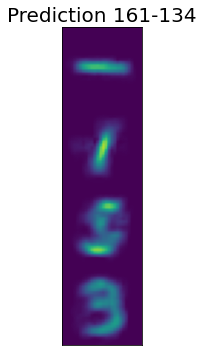

In [ ]:
# Generate random sum for prediction and plot
a = str(random.randint(0,200))
while len(a) < 3:
    a = ' ' + a

b = random.choice(['-','+'])

c = str(random.randint(0,200))
while len(c) < 3:
    c = ' ' + c

inp = a+b+c
print(inp)
onehot_in = encode_labels(inp)

#Prediction
output_prediction = text2img.predict(onehot_in.reshape((1,91)))
print(output_prediction.shape)

# Plot
plt.figure(figsize=(5,5))
plt.imshow(output_prediction[0,:,:,0], vmin=0, vmax=1)
plt.tick_params(axis="both", which="both", bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.title(f'Prediction {inp}', fontsize=20)
plt.tight_layout()
